<a href="https://colab.research.google.com/github/zahra-sharifzadeh/pytorch/blob/main/01_pytorch_workflow_Putting_Together.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# importing module that you need

import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

torch.__version__

'1.13.1+cu116'

In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}") 

Using device: cuda


In [3]:
!nvidia-smi

Tue Mar 28 00:57:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

###1.DATA

In [4]:
# Creat data for regression y = weight * X + bias

weight = 0.7
bias = 0.3

# Creat range values

start = 0
step = 0.02
end = 1

# Creat X and y
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

In [5]:
print("some of X =", X[:5])
print("some of y=", y[:5])
print("length of X:",len(X), "and length of y:", len(y))

some of X = tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800]])
some of y= tensor([[0.3000],
        [0.3140],
        [0.3280],
        [0.3420],
        [0.3560]])
length of X: 50 and length of y: 50


In [6]:
# Train and Test split
Train_split = int(0.8 * len(X))

# Train Data
X_train, y_train = X[:Train_split], y[:Train_split]

# Test Data
X_test, y_test = X[Train_split:], y[Train_split:] 

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [7]:
def plot_prediction(
    train_data=X_train,
    train_labels=y_train,
    test_data=X_test,
    test_labels=y_test,
    predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10,7))

  #plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  #plot testing data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  #plot the predictions is available in red

  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=4, label="Prediction")

  # show the legend
  plt.legend(prop={"size": 14})
  plt.show()


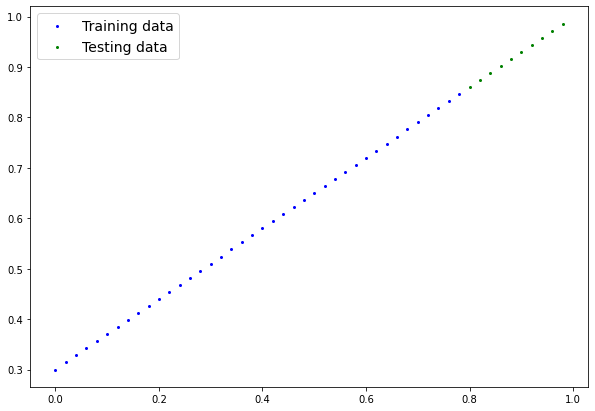

In [8]:
# plot the data 
plot_prediction()

In [9]:
X_train.dtype

torch.float32

###2. Building Linear Model

In [10]:
# Creat A linear model by subclassing nn.module Version 1
class LinearRegressionModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.weghits = nn.Parameter(torch.randn(1,
                                             dtype =torch.float),
                                            requires_grad=True)
                                           
    self.bias = nn.Parameter(torch.randn(1,
                                        dtype=torch.float),
                                         requires_grad=True)
                            
    
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias

In [11]:
model_0 = LinearRegressionModelV1()
model_0, model_0.state_dict()

(LinearRegressionModelV1(),
 OrderedDict([('weghits', tensor([-0.1119])), ('bias', tensor([-1.3950]))]))

In [12]:
# Creat A linear model by subclassing nn.module Version 2
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # Use nn.Linear for creating model parameters
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)
                                  
    
  def forward(self, x: torch.Tensor) -> torch.Tensor:

      return self.linear_layer(x)

    

In [13]:
torch.manual_seed(42)

model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [14]:
print(next(model_1.parameters()).device)

model_1.to(device)

print(next(model_1.parameters()).device)

cpu
cuda:0


In [15]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.8300], device='cuda:0'))])

###3. Training

In [16]:
# Setup loss function
loss_fn  = nn.L1Loss() # MAE

# Setup our optimizer 
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr= 0.01)

In [17]:
### Training

torch.manual_seed(42)

epochs = 200

# Put data on targert device
X_train, y_train = X_train.to(device) , y_train.to(device)
X_test, y_test = X_test.to(device) ,  y_test.to(device)


for epoch in range(epochs):
  
  model_1.train()

  # 1.Forward path
  y_train_pred = model_1(X_train)

  # 2.Calculate the loss
  loss_train = loss_fn(y_train_pred, y_train)

  # 3.Optimizer zero grad
  optimizer.zero_grad()

  # 4. Backpropagation
  loss_train.backward()

  # 5.optimize the model
  optimizer.step()

### Testing
  model_1.eval()

  with torch.inference_mode():

    test_pred = model_1(X_test)

    test_loss = loss_fn(test_pred, y_test)

    # print out result
    if epoch % 10 ==0:
      print(f"Epoch: {epoch} | Trian_Loss: {loss_train} | Test_Loss: {test_loss}")

Epoch: 0 | Trian_Loss: 0.5551779866218567 | Test_Loss: 0.5739762187004089
Epoch: 10 | Trian_Loss: 0.439968079328537 | Test_Loss: 0.4392664134502411
Epoch: 20 | Trian_Loss: 0.3247582018375397 | Test_Loss: 0.30455657839775085
Epoch: 30 | Trian_Loss: 0.20954833924770355 | Test_Loss: 0.16984669864177704
Epoch: 40 | Trian_Loss: 0.09433845430612564 | Test_Loss: 0.03513690456748009
Epoch: 50 | Trian_Loss: 0.023886388167738914 | Test_Loss: 0.04784907028079033
Epoch: 60 | Trian_Loss: 0.019956795498728752 | Test_Loss: 0.045803118497133255
Epoch: 70 | Trian_Loss: 0.016517987474799156 | Test_Loss: 0.037530567497015
Epoch: 80 | Trian_Loss: 0.013089174404740334 | Test_Loss: 0.02994490973651409
Epoch: 90 | Trian_Loss: 0.009653178043663502 | Test_Loss: 0.02167237363755703
Epoch: 100 | Trian_Loss: 0.006215683650225401 | Test_Loss: 0.014086711220443249
Epoch: 110 | Trian_Loss: 0.00278724217787385 | Test_Loss: 0.005814164876937866
Epoch: 120 | Trian_Loss: 0.0012645035749301314 | Test_Loss: 0.013801801018

In [18]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [19]:
weight, bias

(0.7, 0.3)

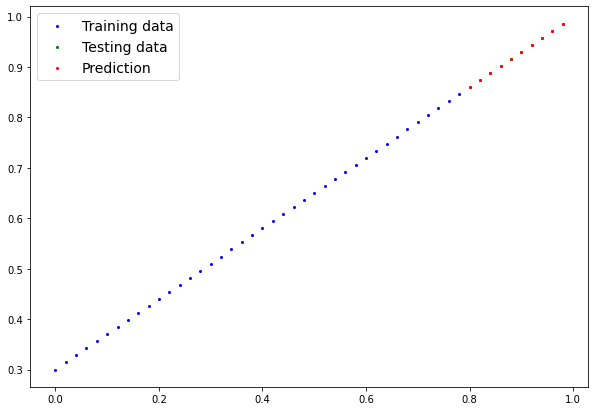

In [20]:
plot_prediction(predictions=test_pred.cpu())

###4. Making and evaluating predictions

In [21]:
# Turn model into evaluation  mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
  y_preds = model_1(X_test)

y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

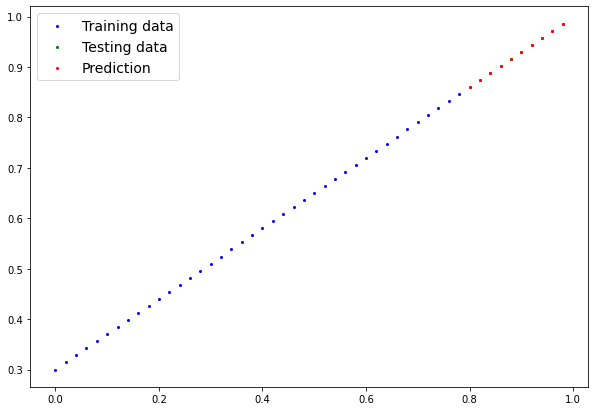

In [22]:
plot_prediction(predictions=test_pred.cpu())

###5. Saving and Loading model

In [23]:
### SAVING MODEL
# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Model save path
MODEL_NAME = "01_pytorch_workflow_Putting_Together_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME



# 3. Save the model as dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(f=MODEL_SAVE_PATH, 
           obj=model_1.state_dict())

Saving model to: models/01_pytorch_workflow_Putting_Together_model_1.pth


In [24]:
### Load a PyTorch 

# creat New instance
loaded_model_1 = LinearRegressionModelV2()

# Load model state dict

loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

loaded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [25]:
next(loaded_model_1.parameters()).device

device(type='cuda', index=0)

In [26]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

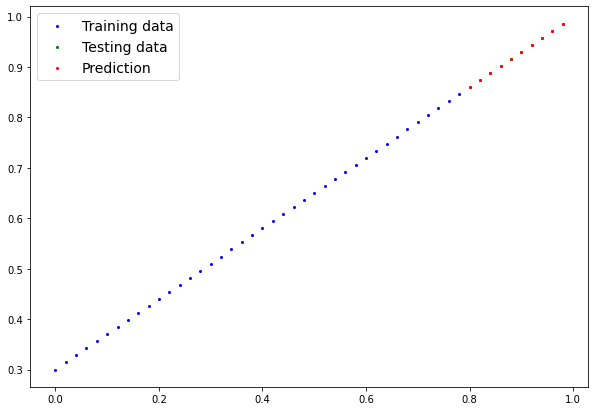

In [27]:
# Evaluate loaded model

loaded_model_1.eval()

with torch.inference_mode():
  loaded_model_pred = loaded_model_1(X_test)

plot_prediction(predictions=loaded_model_pred.cpu())